### Instalar las siguientes librerias

In [ ]:
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install chart_studio
!pip install PyJWT==1.7.1
!pip install scikit-learn==0.23.2
!pip install h5py==2.10.0
!pip install voxelfuse==1.2.6

### Clonar el repositorio 



In [2]:
!git clone https://github.com/Erick832/machine

Cloning into 'machine'...
remote: Enumerating objects: 1898, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 1898 (delta 2), reused 1 (delta 0), pack-reused 1890
Receiving objects: 100% (1898/1898), 341.01 MiB | 16.54 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Checking out files: 100% (1851/1851), done.


### Funcion para poder mostrar objetos

In [19]:
import plotly.io as pio
pio.renderers.default = "colab"

### Bibliotecas

In [4]:
import numpy as np
import pandas as pd
from machine.reconstruction.model import LoadModel
from machine.reconstruction.utils.plot import plot_vol, plot_reconstruction
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [ ]:
#!python -m machine.reconstruction -d modelnet10 -o machine/data/test-vgan --epochs 2 --opt voxels-vgan --overwrite -f
#!python -m machine.reconstruction -d modelnet10 -o machine/data/test-usegan --epochs 20 --opt voxels-usegan --overwrite -f

In [9]:
model = LoadModel('modelnet10', 'machine/data/test-usegan', opt='voxels-usegan', evaluate_mode=True)
# Load data
model._load_full_test_set()
voxels, voxels_target, labels = model.full_test_data

Found 'machine/data/test-usegan/generator_log.csv'
Found 'machine/data/test-usegan/training_log.csv'
Found 'machine/data/test-usegan/model_generator.h5'
Found 'machine/data/test-usegan/discriminator_log.csv'
Found 'machine/data/test-usegan/model_discriminator.h5'


In [10]:
results_1 = model.predict(voxels, labels)
results_2 = model.predict(results_1, labels)

def maskedl1(target, incomplete, result):
    incomplete = incomplete.reshape(-1)
    target = target.reshape(-1)[incomplete == -1]
    result = result.reshape(-1)[incomplete == -1]
    l1 = np.abs(target - result)
    return np.mean(l1)

Loading models...
Loaded weights from files


In [11]:
result_df = pd.DataFrame()

for lbl in np.unique(labels):
    # print(lbl)
    lbl_txt = model.label_encoder.inverse_transform([lbl])
    t_voxels, t_voxels_target = voxels[labels == lbl], voxels_target[labels == lbl]
    t_results_1, t_results_2 = results_1[labels == lbl], results_2[labels == lbl]
    l1_input = maskedl1(t_voxels_target, t_voxels, t_voxels)
    l1_it1 = maskedl1(t_voxels_target, t_voxels, t_results_1)
    l1_it2 = maskedl1(t_voxels_target, t_voxels, t_results_2)
    result_df.loc[lbl, 'label'] = lbl_txt[0]
    result_df.loc[lbl, 'input_l1'] = l1_input
    result_df.loc[lbl, 'result_l1'] = l1_it1
    result_df.loc[lbl, 'result2_l1'] = l1_it2

result_df

,label,input_l1,result_l1,result2_l1
0,chair,0.016733,0.336318,0.470661
1,sofa,0.023149,0.343538,0.482124


In [12]:
results = pd.DataFrame()
for lbl in np.unique(labels):
    t_input = voxels[labels == lbl]
    t_target = voxels_target[labels == lbl]
    t_labels = labels[labels == lbl]
    t_result = model.predict(t_input, t_labels)
#     t_result = model.predict(t, t_labels)
    l1 = np.mean(np.abs(t_target - t_result))
    l1_original = np.mean(np.abs(t_target - t_input))
    txt=model.label_encoder.inverse_transform([lbl]) 
    print(txt[0] + ': %.4f (%.4f)' % (l1, l1_original))

chair: 0.3167 (0.0158)
sofa: 0.3218 (0.0217)


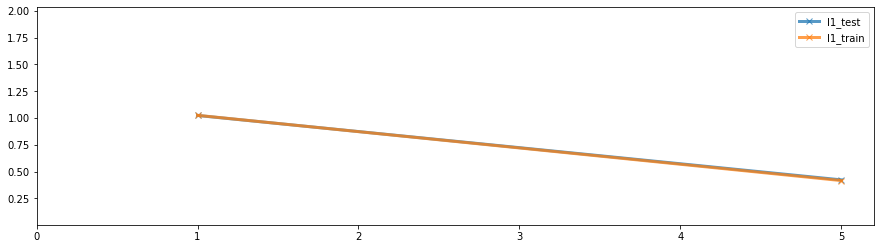

L1 loss per category (test dataset):
chair: 0.3167 (0.0158)
sofa: 0.3218 (0.0217)


In [13]:
train_log = pd.read_csv(model.training_log_file)
plt.figure(figsize=(15,4))
plt.plot(train_log.epoch, train_log.l1_loss_test, '-x', label='l1_test', linewidth=3, alpha=.75)
plt.plot(train_log.epoch, train_log.l1_loss_train, '-x', label='l1_train', linewidth=3, alpha=.75)
plt.ylim(0.0045, 2.0312)
plt.xlim(0)
plt.legend()
plt.show()

print('L1 loss per category (test dataset):')

results = pd.DataFrame()
for lbl in np.unique(labels):
    t_input = voxels[labels == lbl]
    t_target = voxels_target[labels == lbl]
    t_labels = labels[labels == lbl]
    t_result = model.predict(t_input, t_labels)
#     t_result = model.predict(t, t_labels)
    l1 = np.mean(np.abs(t_target - t_result))
    l1_original = np.mean(np.abs(t_target - t_input))
    txt=model.label_encoder.inverse_transform([lbl]) 
    print(txt[0] + ': %.4f (%.4f)' % (l1, l1_original))

In [14]:
model._evaluate(model.full_test_data)

0.42886838

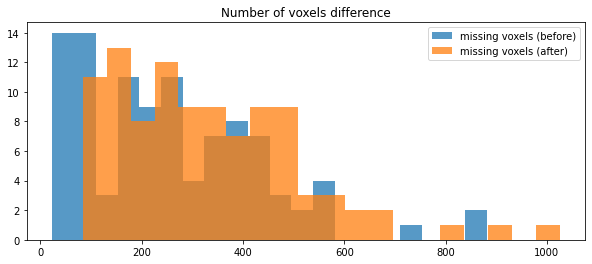

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



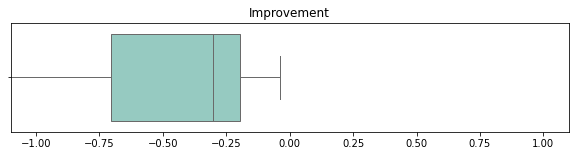

In [15]:
lbl = model.label_encoder.transform(['chair'])[0]
arq_voxels = voxels[labels == lbl]
arq_voxels_target = voxels_target[labels == lbl]
arq_labels = labels[labels == lbl]
arq_result = model.predict(arq_voxels, arq_labels)
# Voxels original difference
voxels_diff = np.logical_xor(arq_voxels_target > 0, arq_voxels > 0)
voxels_diff = voxels_diff.reshape([arq_voxels.shape[0], -1])
voxels_diff = np.sum(voxels_diff, 1)
# Voxels result difference
voxels_result_diff = np.logical_xor(arq_voxels_target > 0, arq_result > 0)
voxels_result_diff = voxels_result_diff.reshape([arq_result.shape[0], -1])
voxels_result_diff = np.sum(voxels_result_diff, 1)
plt.figure(figsize=(10,4))
plt.hist(voxels_diff, bins=20, alpha=.75, label='missing voxels (before)')
plt.hist(voxels_result_diff, bins=20, alpha=.75, label='missing voxels (after)')
plt.title('Number of voxels difference')
plt.legend()
plt.show()
# Show improvement
improvement = (voxels_diff - voxels_result_diff) / voxels_diff
plt.figure(figsize=(10,2))
sns.boxplot(improvement, palette='Set3', linewidth=1, )
plt.title('Improvement')
plt.xlim(-1.1,1.1);

In [16]:
model._load_full_test_set(min_points=1, max_points=2,
                          min_radius=3, max_radius=4, sphere_chance=.9)
voxels, voxels_target, labels = model.full_test_data
result = model.predict(voxels, labels)

arq_voxels, arq_voxels_target, arq_labels, arq_result = voxels, voxels_target, labels, result

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:334: UserWarning:

Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.



In [17]:
lbl = model.label_encoder.transform(['chair'])[0]
arq_voxels = voxels[labels == lbl]
arq_voxels_target = voxels_target[labels == lbl]
arq_labels = labels[labels == lbl]
arq_result = model.predict(arq_voxels, arq_labels)

In [30]:
l1loss = lambda a, b: np.mean(np.abs(a - b))
n = arq_voxels.shape[0]

i = np.random.choice(n)
index = i
print('Complete object:')
plot_vol(arq_voxels_target[i])
n_voxels_target = np.sum(arq_voxels_target[i] == 1)

size = 10
print('Fractured object (l1=%.4f):' % l1loss(arq_voxels_target[i], arq_voxels[i]))
n_voxels = np.sum(arq_voxels[i] == 1)
missing_points = n_voxels_target - n_voxels
perc_missing = missing_points * 100 / n_voxels_target
print(f'Missing voxels: {missing_points} (%.2f%%)' % perc_missing)
plot_vol(arq_voxels[i], s=size)

print('Reconstruction (l1=%.4f):' % l1loss(arq_voxels_target[i], arq_result[i]))
missing_points_result = np.sum((arq_voxels_target[i] + (arq_result[i] > 0)) == 0)
extra_points = np.sum((arq_voxels_target[i] + (arq_result[i] > 0)) == 1)
print(f'Missing voxels    : {missing_points} -> {missing_points_result}')
print(f'Extra voxels added: {extra_points}')
plot_reconstruction(arq_voxels[i], arq_result[i], s=size)
# plot_reconstruction(arq_voxels[i], arq_voxels_target[i], s=size)
rerecon = model.predict_one(arq_result[i], 'chair', decode_label=True)
plot_reconstruction(arq_voxels[i], rerecon[0], s=size)
rererecon = model.predict_one(arq_result[i], 'chair', decode_label=True)
plot_reconstruction(arq_voxels[i], rererecon[0], s=size)

Complete object:


Fractured object (l1=0.0016):
Missing voxels: 27 (0.46%)


Reconstruction (l1=0.2329):
Missing voxels    : 27 -> 27
Extra voxels added: 27


### De voxel a STL


In [31]:
from voxelfuse.voxel_model import VoxelModel, generateMaterials
from voxelfuse.materials import material_properties
from voxelfuse.mesh import Mesh

In [32]:
def convert_to_binary_voxel(input_voxel):
    result=np.zeros((32, 32,32))
    for i in range(32):
        for j in range(32):
            for k in range(32):
                if(input_voxel[i][j][k]==1.0):
                    result[i][j][k]=1
                else:
                    result[i][j][k]=0
    return result

In [33]:
fractured=convert_to_binary_voxel(arq_voxels[index])
target=convert_to_binary_voxel(arq_voxels_target[index])
target=np.logical_xor(fractured, target)

In [34]:
model = VoxelModel(fractured, generateMaterials(4))  #4 is aluminium.
mesh = Mesh.fromVoxelModel(model)
mesh.export('chair_fractured.stl')

Meshing: 100%|██████████| 5341/5341 [00:05<00:00, 1029.42it/s]


In [35]:
model = VoxelModel(target, generateMaterials(4))  #4 is aluminium.
mesh = Mesh.fromVoxelModel(model)
mesh.export('chair_target.stl')

Meshing: 100%|██████████| 27/27 [00:00<00:00, 19660.80it/s]


In [36]:
plot_vol(target, s=size, c=(182,49,62))

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:494: DeprecationWarning:

plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene


